In [6]:
import pandas as pd
import numpy as np
from datetime import date 
import pickle
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('../Documents/resume/Decision-point/Data_Assignment.csv')

In [8]:
data = data.sort_values('Date')
data.head()

,Customer ID,Quantity,Invoice Value,Date
3291314,500646544,0.0,0.0,2018-01-02
4065532,500075476,0.0,0.0,2018-01-02
2571369,500709682,0.0,0.0,2018-01-02
832399,500701892,0.0,0.0,2018-01-02
621386,500643748,0.0,0.0,2018-01-02


In [9]:
print('Total no. of querries: ',data["Customer ID"].count())
print('Total no. of unique customers: ', data['Customer ID'].nunique())

Total no. of querries:  4240880
Total no. of unique customers:  73413


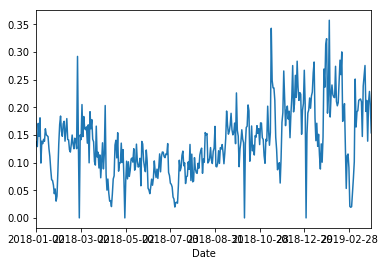

In [10]:
data.groupby(["Date"])["Quantity"].mean().plot()
plt.show()

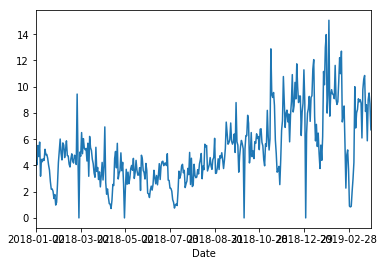

In [11]:
data.groupby(["Date"])["Invoice Value"].mean().plot()
plt.show()

In [12]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

In [13]:
'''
    test train split
'''
test = data[data['year'] >= 2019]
train =  data[data['year'] < 2019]

In [5]:
'''
    Warning: This function takes times, therefore once you complete 
    Feature engineering
    Taking weekly data for each customer
    
    U can use computed results "main_customer_data.p" instead of running this block
'''
import datetime

check_date = 7

sample = train.sort_values('Date')


weekly_quantity = {}
weekly_visit = {}

for i, customer in enumerate(sample['Customer ID'].unique()):
    print(i/len(sample['Customer ID'].unique()))
    customer_data = sample[data['Customer ID']==customer]
    startdate = datetime.datetime.strptime("01-01-2018", "%d-%m-%Y")
    
    i = 0
    week_check = 0
    weekly_quantity[customer] = np.zeros(53)
    weekly_visit[customer] = np.zeros(53)
    while i < len(customer_data):
        
        weekly_quantity_temp = 0
        weekly_visit_temp = 0
        enddate = startdate + datetime.timedelta(days=check_date)
        
        if len(customer_data['Date']) <= i:
                status = False
        elif (customer_data['Date'].iloc[i] < enddate) & (customer_data['Date'].iloc[i] >= startdate):
            status = True
            weekly_visit_temp += 1
        else:
            status = False
#         print(status)
        while status:
            weekly_quantity_temp += customer_data['Quantity'].iloc[i]
            
            i += 1
            if len(customer_data['Date']) <= i:
                status = False
            elif (customer_data['Date'].iloc[i] < enddate) & (customer_data['Date'].iloc[i] >= startdate):
                status = True
                weekly_visit_temp += 1
            else:
                status = False
        startdate = enddate
        weekly_quantity[customer][week_check] = weekly_quantity_temp
        weekly_visit[customer][week_check] = weekly_visit_temp
        week_check = week_check + 1

In [13]:
import pickle
# main_customer_data = pd.concat([pd.DataFrame(weekly_quantity).transpose(), pd.DataFrame(weekly_visit).transpose()], axis=1, sort=False)

# pickle.dump(main_customer_data, open('main_customer_data.p', 'wb'))

main_customer_data = pickle.load(open('main_customer_data.p', 'rb'))

In [15]:
# main_customer_data.shape

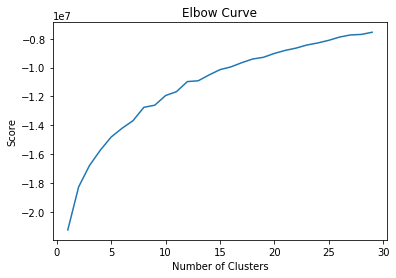

In [19]:
import pandas

import pylab as pl

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

# sample = main_customer_data

Nc = range(1, 30)

kmeans = [KMeans(n_clusters=i) for i in Nc]

# kmeans

score = [kmeans[i].fit(main_customer_data).score(main_customer_data) for i in range(len(kmeans))]

# score

pl.plot(Nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

In [20]:
'''
    Clusturing customers
'''
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12, random_state=0).fit(main_customer_data)

In [1]:
'''
    Checking and recording clustor of each customer
    
    U can use computed results "cluster_data.p" instead of running this block
'''
import pickle
# cluster_data = {}
# clusters = []
# for index in range(0,len(main_customer_data)):
#     temp = kmeans.predict(np.reshape(main_customer_data.values[index], (1, 106)))[0]
#     cluster_data[main_customer_data.index[index]] = temp
#     clusters.append(temp)
# pickle.dump(cluster_data, open('cluster_data.p', 'wb'))

cluster_data = pickle.load(open('cluster_data.p', 'rb'))

In [697]:
'''
    Designing time series for each cluster
    Step 1: Dataset preparation, 
    
    U can use computed results "final_data.p" instead of running this block
'''
# date = {}
# quantity = {}
# sample = train
# for i in range(0, len(sample)):
#     print(i/len(sample), 'Completed')
#     try:
#         if str(cluster_data[sample['Customer ID'].iloc[i]]) in date.keys():
#             date[str(cluster_data[sample['Customer ID'].iloc[i]])].append(sample['Date'].iloc[i])
#             quantity[str(cluster_data[sample['Customer ID'].iloc[i]])].append(sample['Quantity'].iloc[i])
#         else:
#             date[str(cluster_data[sample['Customer ID'].iloc[i]])] = []
#             quantity[str(cluster_data[sample['Customer ID'].iloc[i]])] = []
#             date[str(cluster_data[sample['Customer ID'].iloc[i]])].append(sample['Date'].iloc[i])
#             quantity[str(cluster_data[sample['Customer ID'].iloc[i]])].append(sample['Quantity'].iloc[i])
#     except Exception as e:
#         print(e)
#         pass

final_data = pickle.load(open('final_data.p', 'rb'))
date = final_data[0]
quantity = final_data[0]

In [698]:
'''
    No. of customer in each cluster
'''
for i in range(0, 12):
    print('Cluster ',i, ': ', len(date[str(i)]))

Cluster  0 :  375462
Cluster  1 :  1472612
Cluster  2 :  198
Cluster  3 :  1058
Cluster  4 :  210
Cluster  5 :  41
Cluster  6 :  1570
Cluster  7 :  74
Cluster  8 :  17670
Cluster  9 :  1529163
Cluster  10 :  249
Cluster  11 :  89


In [14]:
'''
    Step2 : Model training for each customer category
'''
from fbprophet import Prophet
from math import *
m = {}

for key in date.keys():
#     key = '0'
    data_temp = pd.DataFrame(quantity[key], columns=['Quantity'])
    data_temp['Date'] = date[key]

    final_quantity = []
    final_date = []
    for date_index in data_temp['Date'].unique(): 
        data_temp_sub = data_temp[data_temp['Date']==date_index]
        final_date.append(date_index)
        final_quantity.append(np.mean(data_temp_sub[data_temp_sub['Date']==date_index].Quantity))

    final_data = pd.DataFrame([log(i+1) for i in final_quantity], columns=['y'])
    final_data['ds'] = final_date

    m[key] = Prophet()
    m[key].fit(final_data)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [14]:
# pickle.dump(m, open('time-series-model.p', 'wb'))
cluster_data = pickle.load(open('cluster_data.p', 'rb'))
m = pickle.load(open('time-series-model.p', 'rb'))

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


customer cluster:  0
customer cluster:  1
customer cluster:  2
customer cluster:  3
customer cluster:  4
customer cluster:  5
customer cluster:  6
customer cluster:  7
customer cluster:  8
customer cluster:  9
customer cluster:  10
customer cluster:  11


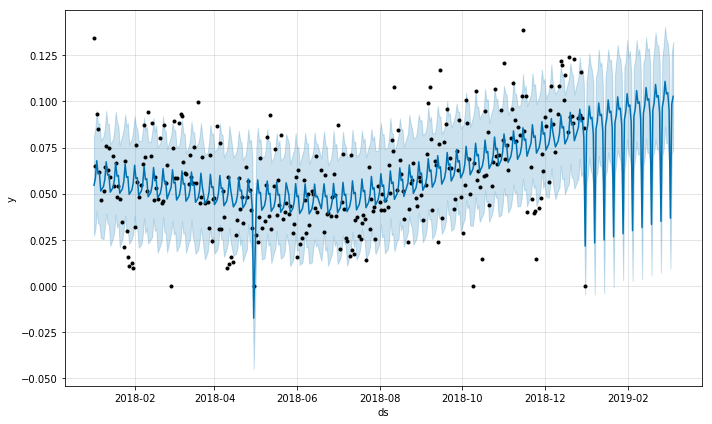

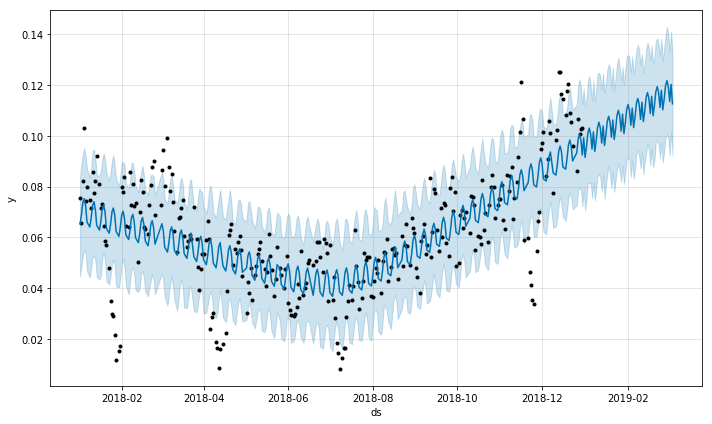

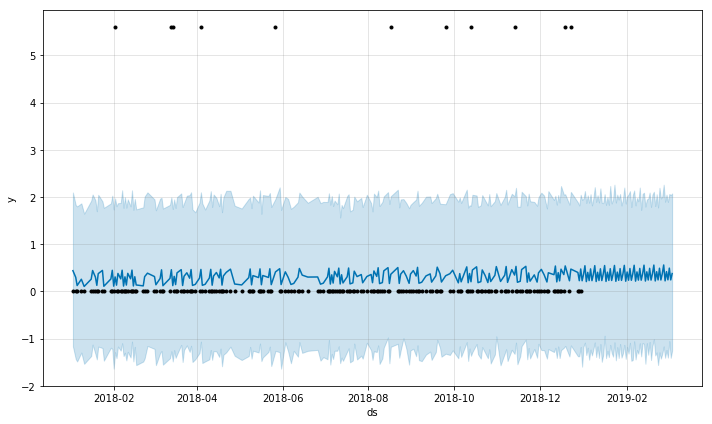

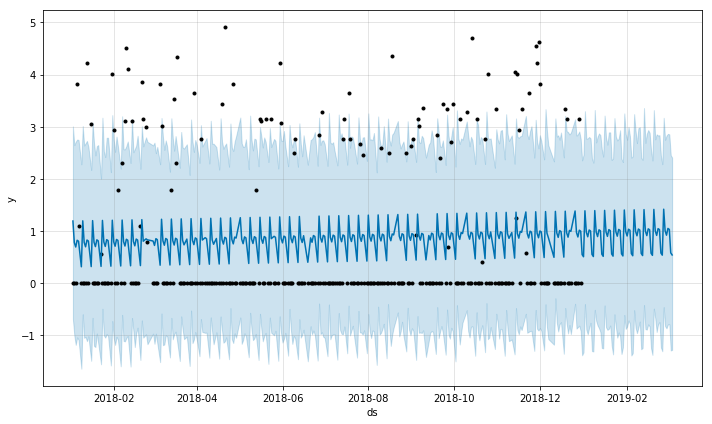

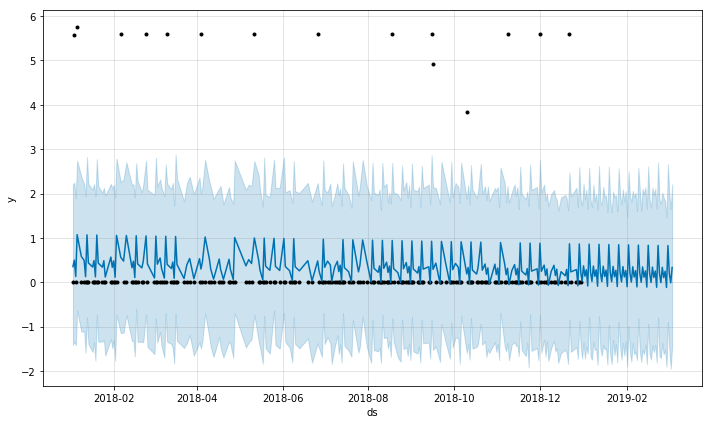

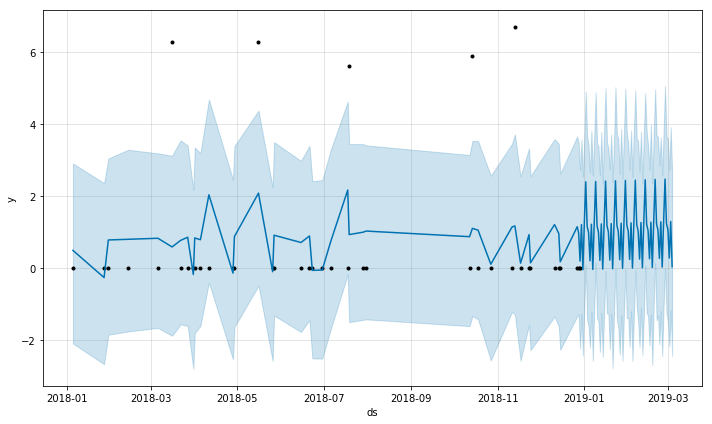

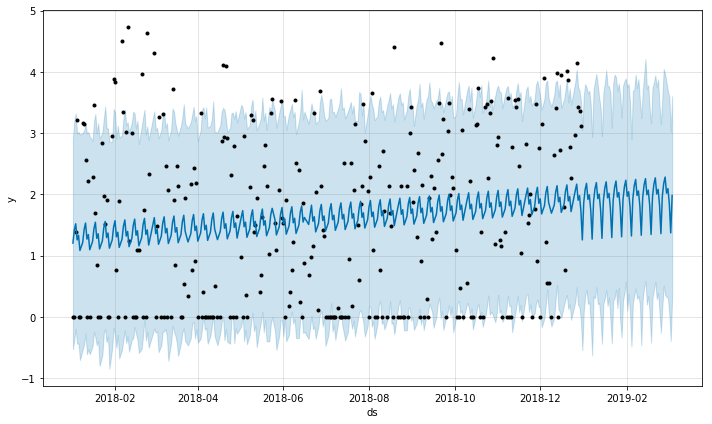

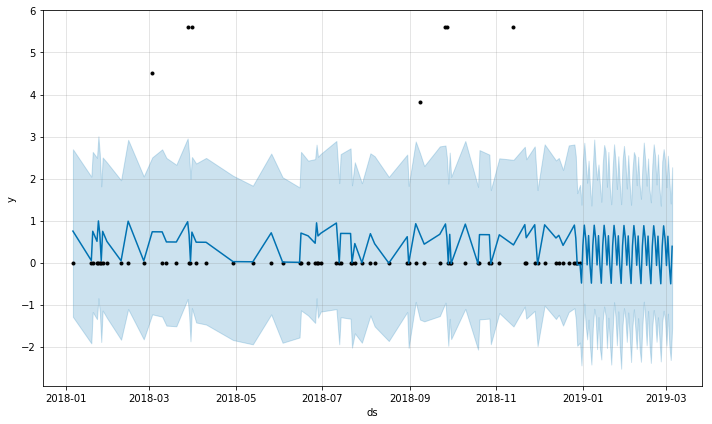

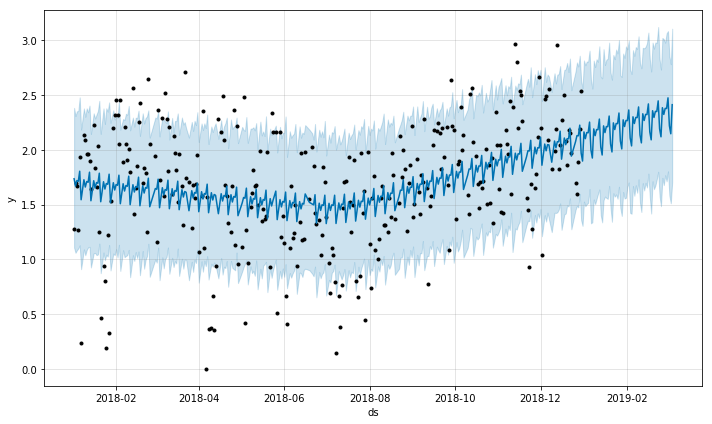

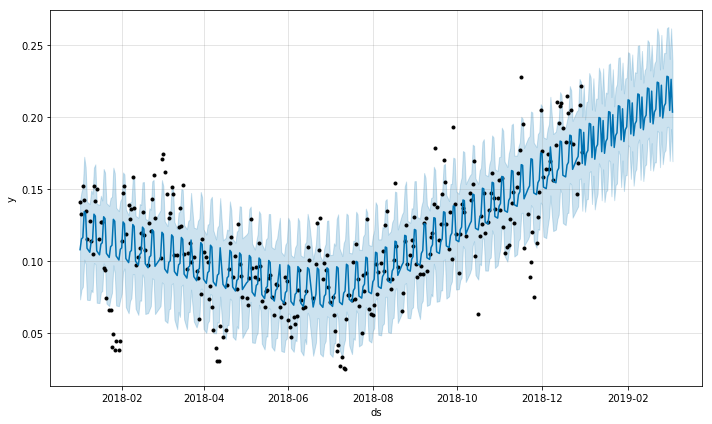

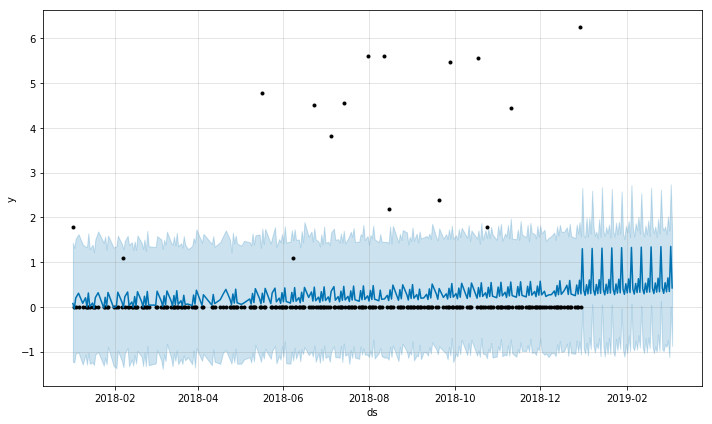

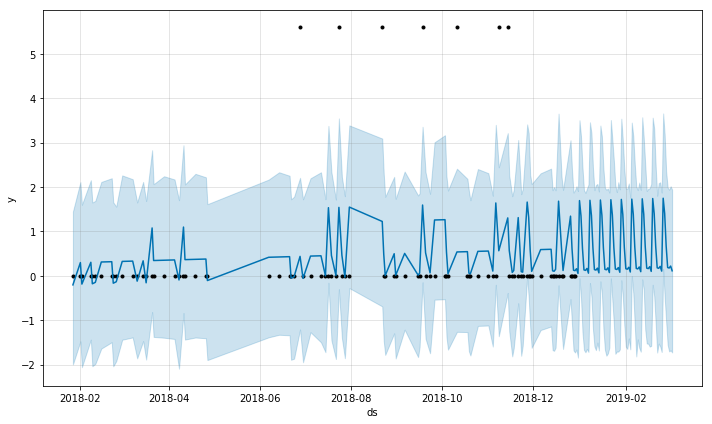

In [26]:
'''
    Testing of data
    Step 1 data generation
    Step 2 Accuracy testing with original data
'''
for key in range(0,12):
    print('customer cluster: ',str(key))
    future = m[str(key)].make_future_dataframe(periods=65)
    # future.tail()
    forecast = m[str(key)].predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m[str(key)].plot(forecast)
    

In [84]:
'''
    Warrning: this function takes time, therefore once you have done save your results
    
'''
predicted_value = {}
predicted_date = {}
customer_id = {}
original_value = {}
forecast = {}
new_cutomer_2019 = []
for key in range(0,12):
    future = m[str(key)].make_future_dataframe(periods=91)

    forecast[str(key)] = m[str(key)].predict(future)
    predicted_value[str(key)] = []
    predicted_date[str(key)] = []
    customer_id[str(key)] = []
    original_value[str(key)] = []

for cust_id in test['Customer ID'].unique():
    try:
        key = cluster_data[cust_id]
        sub_data = test[test['Customer ID'] == cust_id]

        for day in sub_data['Date']:
            predicted_value[str(key)].append(forecast[str(key)][forecast[str(key)]['ds']==day]['yhat'].values[0])
            predicted_date[str(key)].append(sub_data['Date'].iloc[0])
            original_value[str(key)].append(sub_data[sub_data['Date']==day]['Quantity'].values[0])
            customer_id[str(key)].append(cust_id)
    except:
        new_cutomer_2019.append(cust_id)

In [91]:
'''
    R2
'''
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
for key in range(0,12):
    
    print('r2 of class ', key,': ', mean_squared_error(original_value[str(key)], predicted_value[str(key)])) 

r2 of class  0 :  0.8994080333916888
r2 of class  1 :  0.7337713257115268
r2 of class  2 :  7128.297041751548
r2 of class  3 :  1488.4296406114743
r2 of class  4 :  7441.612342812365
r2 of class  5 :  78220.9965829099
r2 of class  6 :  4566.923718961302
r2 of class  7 :  8066.77121102949
r2 of class  8 :  475.012994127822
r2 of class  9 :  2.5487598837675787
r2 of class  10 :  8486.402249150953
r2 of class  11 :  13641.821676788511


In [95]:
'''
    Precision
'''
# key = 0
# plt.scatter(original_value[str(key)], predicted_value[str(key)])
data_temp = pd.DataFrame(original_value[str(key)], columns=['Original'])
data_temp['Predicted'] = predicted_value[str(key)]

data_temp.to_csv('data_temp.csv')

In [702]:
'''
    Precision:- in all of the cases where you predicted an invoice to be happen in how many case outlet actually invoiced the noodles

(Invoiced Predicted and Actually happened)/(Total Invoice Predicted)

·  Recall:- out of all of the invoices happened actually how many your model was able to predict

(Invoiced Predicted and Actually happened)/(Total Invoice Actually happened)  

·  Non-Zero Accuracy:- out of total invoices happened actually, percentage of invoices where you were able to predict the exact quantity


'''
class_bar ={}
binary_result = {}
original_binary = {}

class_bar['0'] = 0.09
class_bar['1'] = 0.1
class_bar['2'] = 0.22
class_bar['3'] = 0.9
class_bar['4'] = -0.12
class_bar['5'] = 1.0
class_bar['6'] = 2.0
class_bar['7'] = 0.5
class_bar['8'] = 2.1
class_bar['9'] = 0.18
class_bar['10'] = 0.4
class_bar['11'] = 0.18

for key in range(0, 12):
    binary_result[str(key)] = []
    original_binary[str(key)] = []
    for i, x in enumerate(predicted_value[str(key)]):
        if(x >class_bar[str(key)]):
            binary_result[str(key)].append(1)
        else:
            binary_result[str(key)].append(0)
            
        if(original_value[str(key)][i] >= 1):
            original_binary[str(key)].append(1)
        else:
            original_binary[str(key)].append(0)

In [692]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

for key in range(0,12):
    conf_matrix = confusion_matrix(original_binary[str(key)], binary_result[str(key)])
    print('Precision of class ',key, ': ',precision_score(original_binary[str(key)], binary_result[str(key)]))
    print('Recall of class ',key, ': ',recall_score(original_binary[str(key)], binary_result[str(key)]))
    print('Non-Zero accuracy of class ', key,': ', np.sum(np.array(binary_result[str(key)])[np.array(binary_result[str(key)]) == np.array(original_binary[str(key)])])/np.sum(original_value[str(key)]))

Precision of class  0 :  0.062000477704080695
Recall of class  0 :  0.8883769909174675
Non-Zero accuracy of class  0 :  0.5481792634725471
Precision of class  1 :  0.06708762373375643
Recall of class  1 :  0.8982926934159033
Non-Zero accuracy of class  1 :  0.6121385300440364
Precision of class  2 :  0.08695652173913043
Recall of class  2 :  0.8
Non-Zero accuracy of class  2 :  0.002962962962962963
Precision of class  3 :  0.10837438423645321
Recall of class  3 :  0.7586206896551724
Non-Zero accuracy of class  3 :  0.007977277811963232
Precision of class  4 :  0.06666666666666667
Recall of class  4 :  0.6
Non-Zero accuracy of class  4 :  0.0022222222222222222
Precision of class  5 :  0.2727272727272727
Recall of class  5 :  1.0
Non-Zero accuracy of class  5 :  0.001851851851851852
Precision of class  6 :  0.19921875
Recall of class  6 :  0.6455696202531646
Non-Zero accuracy of class  6 :  0.006601087237898007
Precision of class  7 :  0.16666666666666666
Recall of class  7 :  1.0
Non-Ze